## VrInstrumental Variables Example

In [1]:
# Copyright [2021] [Alessio Russo - alessior@kth.se]  
# This file is part of PythonVRFT.
# PythonVRFT is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, version 3 of the License.
# PythonVRFT is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
# You should have received a copy of the GNU General Public License
# along with PythonVRFT.  If not, see <http://www.gnu.org/licenses/>.
#
# Code author: [Alessio Russo - alessior@kth.se]
# Last update: 08th January 2020, by alessior@kth.se
#

# Example 3
# ------------
# In this example we see how to apply VRFT to a simple SISO model
# with  measurement noise using instrumental variables
# Input data is generated using random normal noise
#

### Load libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as scipysig
from vrft import *

### System, Reference Model and Control law

In [3]:
# System
dt = 1e-2
num = [0.5]
den = [1, -0.9]
sys = ExtendedTF(num, den, dt=dt)
sigma = 0.5  # measurement noise

# Reference Model
refModel = ExtendedTF([0.6], [1, -0.4], dt=dt)

# Control law
control = [ExtendedTF([1], [1, -1], dt=dt),
        ExtendedTF([1, 0], [1, -1], dt=dt)]



### Generate signals

In [4]:
# Function used to generate the data
def generate_data(sys, u, t, sigma):
    t, y = scipysig.dlsim(sys, u, t)
    y = y.flatten() + sigma * np.random.normal(size = t.size)

    # Length of the initial condition depends on the reference model
    return iddata(y, u, dt, [0])

# Generate input siganl
t_start = 0
t_end = 10
t = np.arange(t_start, t_end, dt)
u = np.random.normal(size = t.size)

# To use IV we must perform 2 experiments on the plant using the same input
data1 = generate_data(sys, u, t, sigma)
data2 = generate_data(sys, u, t, sigma)
data = [data1, data2]


### VRFT

In [5]:
# VRFT Pre-filter
prefilter = refModel * (1 -  refModel)

# VRFT method with Instrumental variables
theta_iv, r_iv, loss_iv, C_iv = compute_vrft(data, refModel, control, prefilter, iv=True)

# VRFT method without Instrumental variables
theta_noiv, r_noiv, loss_noiv, C_noiv = compute_vrft(data1, refModel, control, prefilter, iv=False)

#Obtained controller
print('------IV------')
print("Loss: {}\nTheta: {}\nController: {}".format(loss_iv, theta_iv, C_iv))
print('------No IV------')
print("Loss: {}\nTheta: {}\nController: {}".format(loss_noiv, theta_noiv, C_noiv))

------IV------
Loss: 0.9212933606914391
Theta: [-1.18142645  1.27724244]
Controller: ExtendedTF(
array([ 1.27724244, -1.18142645]),
array([ 1., -1.]),
dt: 0.01
)
------No IV------
Loss: 0.2898010354223657
Theta: [-0.35784632  0.45149128]
Controller: ExtendedTF(
array([ 0.45149128, -0.35784632]),
array([ 1., -1.]),
dt: 0.01
)


### Verify performance

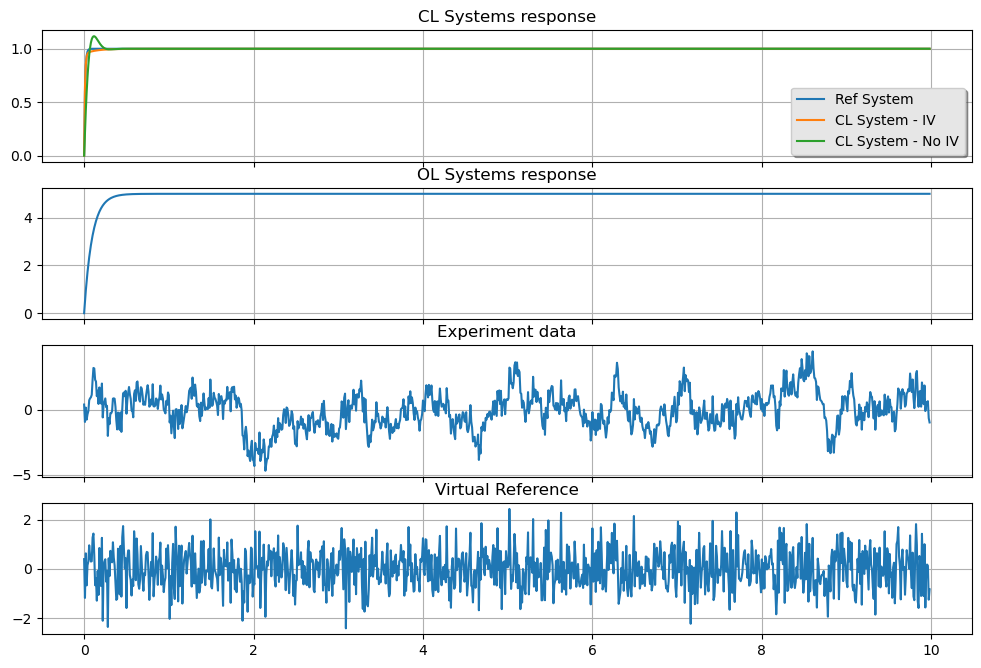

In [6]:
# Closed loop system
closed_loop_iv = (C_iv * sys).feedback()
closed_loop_noiv = (C_noiv * sys).feedback()

t = t[:len(r_iv)]
u = np.ones(len(t))

_, yr = scipysig.dlsim(refModel, u, t)
_, yc_iv = scipysig.dlsim(closed_loop_iv, u, t)
_, yc_noiv = scipysig.dlsim(closed_loop_noiv, u, t)
_, ys = scipysig.dlsim(sys, u, t)

yr = yr.flatten()
ys = ys.flatten()
yc_noiv = yc_noiv.flatten()
yc_iv = yc_iv.flatten()

fig, ax = plt.subplots(4, sharex=True, figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
ax[0].plot(t, yr,label='Reference System')
ax[0].plot(t, yc_iv, label='CL System - IV')
ax[0].plot(t, yc_noiv, label='CL System - No IV')
ax[0].set_title('CL Systems response')
ax[0].grid(True)
ax[1].plot(t, ys, label='OL System')
ax[1].set_title('OL Systems response')
ax[1].grid(True)
ax[2].plot(t, data1.y[:len(r_iv)])
ax[2].grid(True)
ax[2].set_title('Experiment data')
ax[3].plot(t, r_iv)
ax[3].grid(True)
ax[3].set_title('Virtual Reference')

# Now add the legend with some customizations.
legend = ax[0].legend(loc='lower right', shadow=True)

# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')


plt.show()
